<a href="https://www.kaggle.com/code/shreyasdomde/weather-detection?scriptVersionId=166135518" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, callbacks

import warnings
warnings.filterwarnings("ignore")

2024-03-09 08:15:22.471230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 08:15:22.471328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 08:15:22.595130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [3]:
datadir = '/kaggle/input/weather-dataset/dataset'

# 😶‍🌫️ Exploring the dataset

In [4]:
climates = {cl: len(os.listdir(os.path.join(datadir, cl))) for cl in os.listdir(datadir)}

<Axes: >

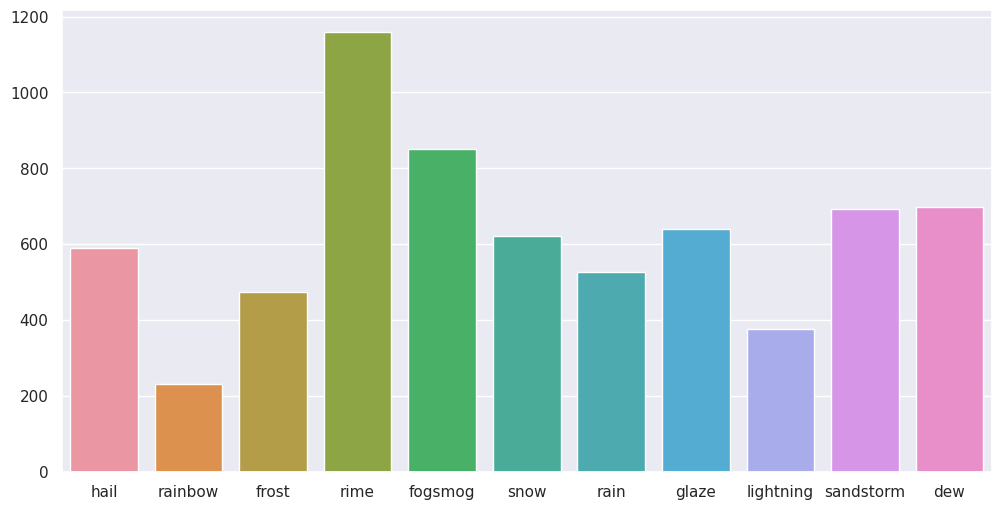

In [5]:
sns.set(rc={"figure.figsize":(12, 6)})
sns.barplot(x=list(climates.keys()), y=list(climates.values()))

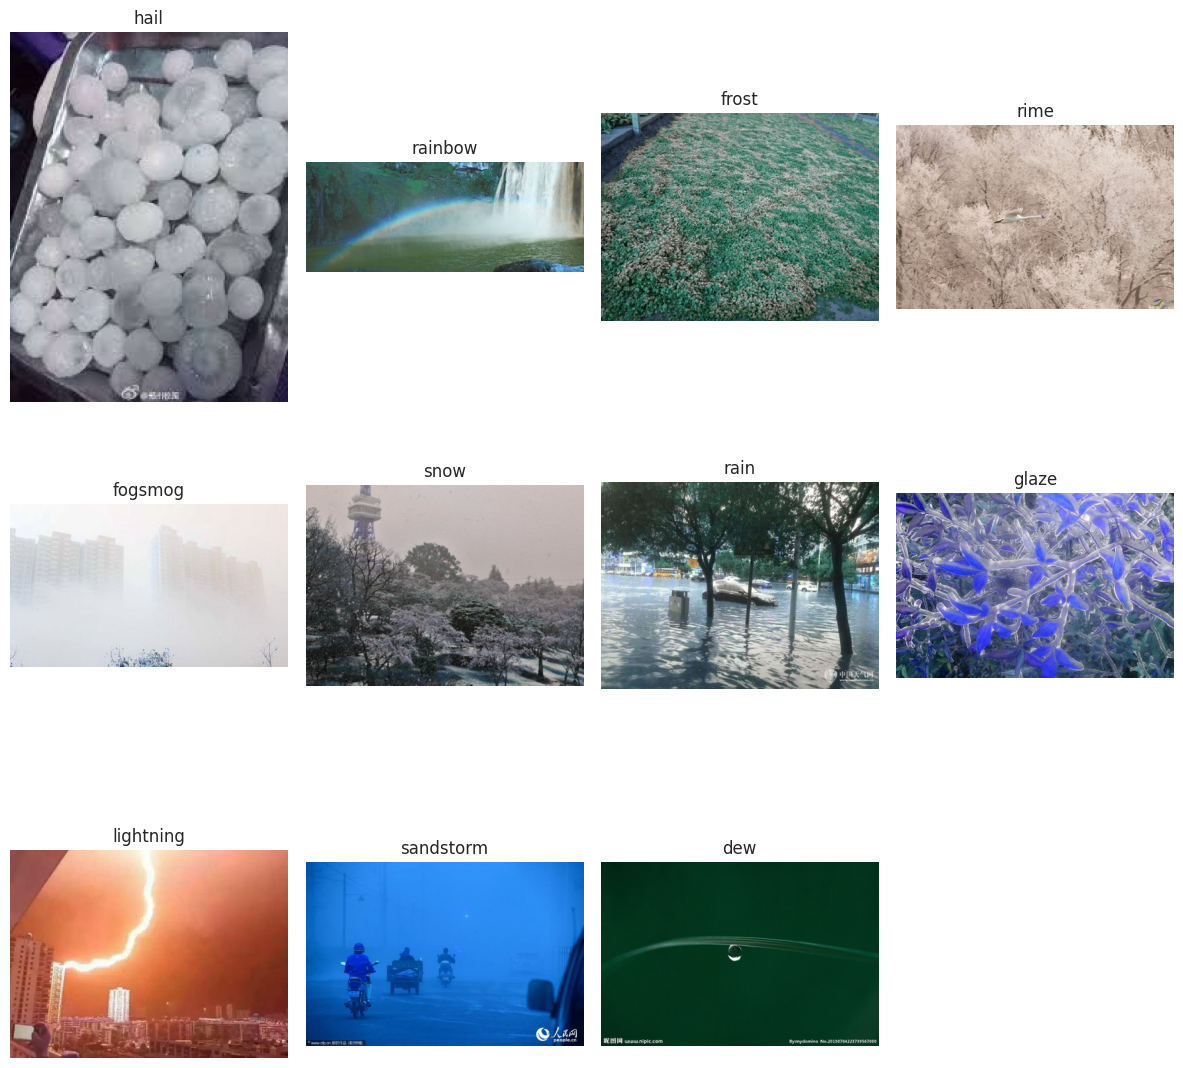

In [6]:
fig = plt.figure(figsize=(12, 12)) 
rows = 3
columns = 4

for i, cl in enumerate(climates.keys()):
    img_name = os.listdir(os.path.join(datadir, cl))[random.randrange(0, 100)]
    img_path = os.path.join(datadir, cl, img_name)
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(img)
    plt.title(cl)
    
plt.tight_layout()
plt.show()

# ✂️ Splittinng dataset

In [7]:
filepaths = []
labels = []
for i in climates.keys():
    img_path = datadir+'/'+i
    for imgs in os.listdir(img_path):
        filepaths.append(os.path.join(img_path, imgs))
        labels.append(i)
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [8]:
df.head()

,filepaths,labels
0,/kaggle/input/weather-dataset/dataset/hail/010...,hail
1,/kaggle/input/weather-dataset/dataset/hail/037...,hail
2,/kaggle/input/weather-dataset/dataset/hail/028...,hail
3,/kaggle/input/weather-dataset/dataset/hail/007...,hail
4,/kaggle/input/weather-dataset/dataset/hail/007...,hail


# 🎋 Preprocessing Images

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=44) 

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    validation_split=0.2
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [11]:
train_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'training'
)

val_data = train_datagen.flow_from_dataframe(
    df_train,
    x_col = 'filepaths',
    y_col = 'labels',
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset='validation'
)

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.


In [12]:
test_data = train_datagen.flow_from_dataframe(
    df_test, 
    x_col = 'filepaths',
    y_col = 'labels',
    color_mode = 'rgb',
    batch_size = 64
)

Found 1373 validated image filenames belonging to 11 classes.


# 🪸 Training models

### Trial model 
model = tf.keras.Sequential([
    
    layers.Resizing(100, 100),
    layers.Rescaling(1./255),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=256, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    
    layers.Dense(units=11, activation='softmax'),
])

In [13]:
# defining hyperparameters

EPOCHS = 10
height, width = 150, 150

In [14]:
class Model_builder:
    
    def __init__(self, pretrained_model):
        self.model = self.build_model(pretrained_model)
    
    def build_model(self, pretrained_model):

        for layer in pretrained_model.layers:
            layer.trainable = False

        model = tf.keras.Sequential()
        model.add(layers.Resizing(height, width))
        model.add(layers.Rescaling(1/255.0))
        model.add(pretrained_model)

        model.add(layers.Flatten())
        model.add(layers.Dense(units=256, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())

        model.add(layers.Dense(units=11, activation='softmax'))
        
        return model
    
    def compile_model(self, opt):
        self.model.compile(
            optimizer = opt,
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
        )
    
    def model_summary(self):
        self.model.build((None, height, width, 3))
        self.model.summary()
        
    def get_model(self):
        return self.model
    

### 1.VGG16

In [15]:
vgg_pretrained = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))
vgg_model = Model_builder(vgg_pretrained)
vgg_model.compile_model('adam')
vgg_model.model_summary()
vgg_model = vgg_model.get_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,815,947 (64.15 MB)

 Trainable params: 2,100,747 (8.01 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

In [16]:
with tf.device('/device:GPU:0'):
    
    vgg_history = vgg_model.fit(
            train_data,
            validation_data = val_data,
            epochs = EPOCHS,
            batch_size = 64,
        )

Epoch 1/10
  1/138 ━━━━━━━━━━━━━━━━━━━━ 44:12 19s/step - accuracy: 0.0625 - loss: 2.8737

I0000 00:00:1709972170.520340      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709972170.546143      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/138 ━━━━━━━━━━━━━━━━━━━━ 3:11 1s/step - accuracy: 0.0883 - loss: 2.9083

W0000 00:00:1709972179.269343      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.4984 - loss: 1.5385

W0000 00:00:1709972258.525277      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


138/138 ━━━━━━━━━━━━━━━━━━━━ 131s 817ms/step - accuracy: 0.5001 - loss: 1.5328 - val_accuracy: 0.6882 - val_loss: 1.2185
Epoch 2/10


W0000 00:00:1709972282.435247      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 572ms/step - accuracy: 0.7289 - loss: 0.7848 - val_accuracy: 0.7366 - val_loss: 0.8918
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 578ms/step - accuracy: 0.7744 - loss: 0.6876 - val_accuracy: 0.7019 - val_loss: 1.0707
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 580ms/step - accuracy: 0.7916 - loss: 0.6421 - val_accuracy: 0.7329 - val_loss: 1.0532
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 574ms/step - accuracy: 0.8142 - loss: 0.5695 - val_accuracy: 0.7530 - val_loss: 0.8783
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 143s 579ms/step - accuracy: 0.8135 - loss: 0.5849 - val_accuracy: 0.7411 - val_loss: 1.0164
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 580ms/step - accuracy: 0.8025 - loss: 0.5889 - val_accuracy: 0.7119 - val_loss: 1.1308
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 575ms/step - accuracy: 0.8226 - loss: 0.5275 - val_accuracy: 0.7274 - val_loss: 1.0634
Epoch 9/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 574ms/step - accuracy: 0.8393 - loss: 0.5062 - va

### 2.ResNet50

In [17]:
resnet_pretrained = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))
resnet_model = Model_builder(resnet_pretrained)
resnet_model.compile_model('adam')
resnet_model.model_summary()
resnet_model = resnet_model.get_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,699,019 (140.00 MB)

 Trainable params: 13,110,795 (50.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [18]:
with tf.device('/device:GPU:0'):
    
    resnet_history = resnet_model.fit(
            train_data,
            validation_data = val_data,
            epochs = EPOCHS,
            batch_size = 64
        )

Epoch 1/10
  1/138 ━━━━━━━━━━━━━━━━━━━━ 47:43 21s/step - accuracy: 0.2500 - loss: 2.4157

W0000 00:00:1709973116.957483      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


137/138 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.1900 - loss: 2.3895

W0000 00:00:1709973192.760629      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


138/138 ━━━━━━━━━━━━━━━━━━━━ 117s 698ms/step - accuracy: 0.1905 - loss: 2.3868 - val_accuracy: 0.2726 - val_loss: 2.0158
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 117s 572ms/step - accuracy: 0.2793 - loss: 1.9742 - val_accuracy: 0.2206 - val_loss: 2.1106
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 579ms/step - accuracy: 0.3153 - loss: 1.8988 - val_accuracy: 0.1814 - val_loss: 2.2255
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 579ms/step - accuracy: 0.3284 - loss: 1.8608 - val_accuracy: 0.1440 - val_loss: 2.3727
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 577ms/step - accuracy: 0.3264 - loss: 1.8965 - val_accuracy: 0.2270 - val_loss: 2.2334
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 576ms/step - accuracy: 0.3135 - loss: 1.8974 - val_accuracy: 0.2397 - val_loss: 1.9763
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 580ms/step - accuracy: 0.3273 - loss: 1.8639 - val_accuracy: 0.3428 - val_loss: 1.8344
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 579ms/step - accuracy: 0.3357 - loss: 1.8777 - v

### 3.Xception

In [19]:
xception_pretrained = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(height, width, 3))
xception_model = Model_builder(xception_pretrained)
xception_model.compile_model('adam')
xception_model.model_summary()
xception_model = xception_model.get_model()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,972,787 (129.60 MB)

 Trainable params: 13,110,795 (50.01 MB)

 Non-trainable params: 20,861,992 (79.58 MB)

In [20]:
with tf.device('/device:GPU:0'):
    
    xception_history = xception_model.fit(
            train_data,
            validation_data = val_data,
            epochs = EPOCHS,
            batch_size = 64
        )

Epoch 1/10
  1/138 ━━━━━━━━━━━━━━━━━━━━ 42:11 18s/step - accuracy: 0.1875 - loss: 2.6636

W0000 00:00:1709974022.193534      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.5359 - loss: 1.5551

W0000 00:00:1709974096.335670      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


138/138 ━━━━━━━━━━━━━━━━━━━━ 113s 687ms/step - accuracy: 0.5367 - loss: 1.5519 - val_accuracy: 0.7384 - val_loss: 0.9159
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 577ms/step - accuracy: 0.7568 - loss: 0.7206 - val_accuracy: 0.7666 - val_loss: 0.6716
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 574ms/step - accuracy: 0.8126 - loss: 0.5736 - val_accuracy: 0.7703 - val_loss: 0.6828
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 576ms/step - accuracy: 0.8249 - loss: 0.5212 - val_accuracy: 0.7712 - val_loss: 0.6921
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 577ms/step - accuracy: 0.8472 - loss: 0.4477 - val_accuracy: 0.7821 - val_loss: 0.6787
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 577ms/step - accuracy: 0.8553 - loss: 0.4219 - val_accuracy: 0.7858 - val_loss: 0.6888
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 575ms/step - accuracy: 0.8561 - loss: 0.4218 - val_accuracy: 0.7912 - val_loss: 0.6008
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 144s 587ms/step - accuracy: 0.8662 - loss: 0.4063 - v

# 🧩Evaluating model

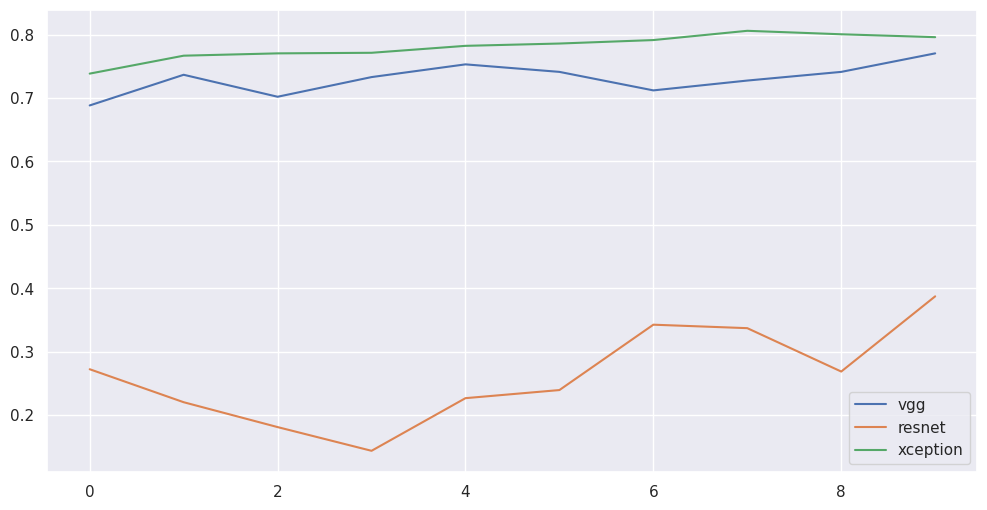

In [21]:
plt.plot([i for i in range(EPOCHS)], vgg_history.history['val_accuracy'])
plt.plot([i for i in range(EPOCHS)], resnet_history.history['val_accuracy'])
plt.plot([i for i in range(EPOCHS)], xception_history.history['val_accuracy'])
plt.legend(['vgg', 'resnet', 'xception'])
plt.show()

<div style='background-color:#d0bdf4; color:black; text-align:center'> 
    Since, Xception is the performing best in early 10 epochs<br>
    we will train it on more epochs to build our model
<center><img src='https://media2.giphy.com/media/SvuYYhf9IuL1fEXq4q/200w.webp?cid=ecf05e47xxpr49vt9ioo8yv14ilsi660fz5fimac7c7thctk&rid=200w.webp&ct=s' height=150px width=200px></center>
</div>

In [22]:
epo = 100
early_stop = callbacks.EarlyStopping(
    patience=10,
    monitor='val_loss'
)
reduceLr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor= 0.2,
    patience= 5
)

In [23]:
with tf.device('/device:GPU:0'):
    
    xception_history = xception_model.fit(
            train_data,
            validation_data = val_data,
            epochs = epo,
            batch_size = 64,
            callbacks = [early_stop, reduceLr]
        )

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 84s 583ms/step - accuracy: 0.8856 - loss: 0.3305 - val_accuracy: 0.7894 - val_loss: 0.6668 - learning_rate: 0.0010
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 578ms/step - accuracy: 0.8804 - loss: 0.3505 - val_accuracy: 0.8204 - val_loss: 0.5978 - learning_rate: 0.0010
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 582ms/step - accuracy: 0.8917 - loss: 0.3267 - val_accuracy: 0.7967 - val_loss: 0.6548 - learning_rate: 0.0010
Epoch 4/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 575ms/step - accuracy: 0.8814 - loss: 0.3519 - val_accuracy: 0.8040 - val_loss: 0.6326 - learning_rate: 0.0010
Epoch 5/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 575ms/step - accuracy: 0.8855 - loss: 0.3330 - val_accuracy: 0.8040 - val_loss: 0.5887 - learning_rate: 0.0010
Epoch 6/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 574ms/step - accuracy: 0.8977 - loss: 0.3051 - val_accuracy: 0.8149 - val_loss: 0.6166 - learning_rate: 0.0010
Epoch 7/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 582ms/step - accura

# 🐉Predicting Images of test data

In [24]:
y_pred = xception_model.predict(test_data)

 1/22 ━━━━━━━━━━━━━━━━━━━━ 3:40 10s/step

W0000 00:00:1709976836.436137      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step


W0000 00:00:1709976870.773273      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


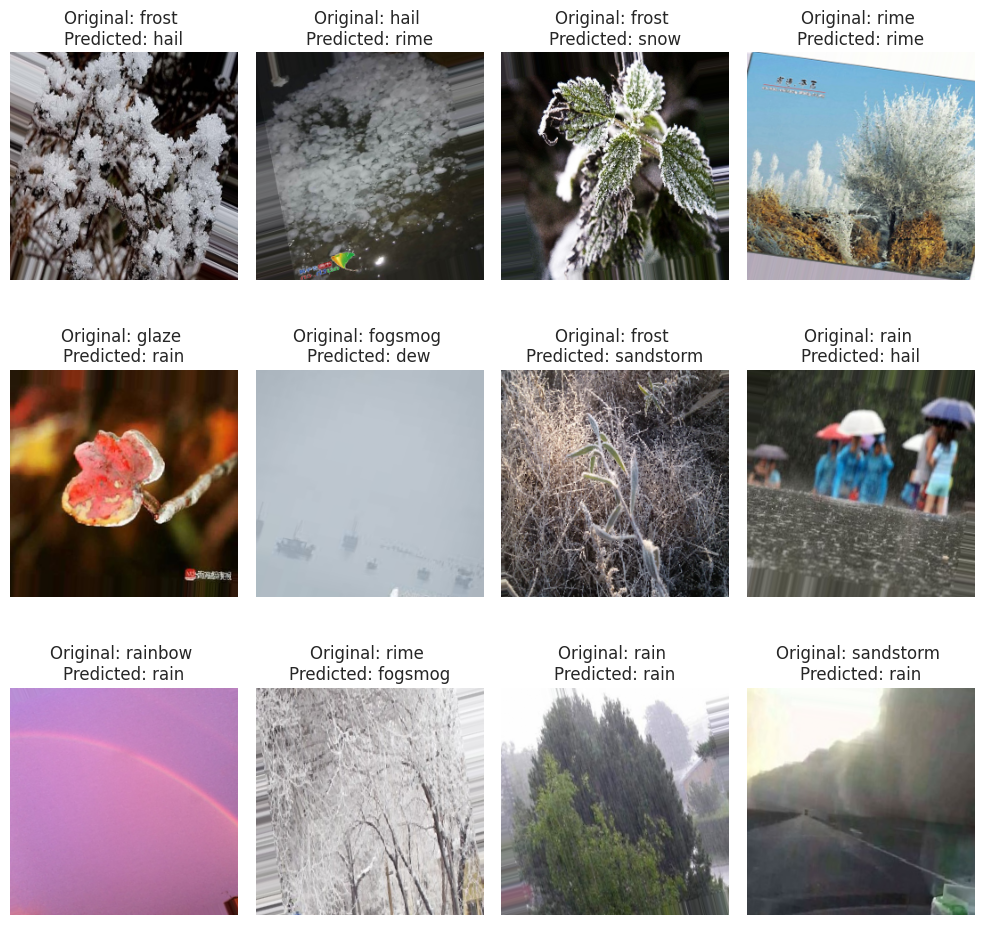

In [25]:
classes = {val:key for key, val in test_data.class_indices.items()}

def vis_pred(ind):
    rows, columns = 3, 4
    x, y = next(iter(test_data))
    fig = plt.figure(figsize=(10, 10))
    for i in range(rows * columns):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(x[ind+i] / 255)
        plt.title(f'Original: {classes[np.argmax(y[ind + i])]} \nPredicted: {classes[np.argmax(y_pred[ind + i])]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
vis_pred(10)